## *Required Libraries*

In [1]:
import os
import pickle
import numpy as np
from tqdm import tqdm
from tensorflow.keras.applications.vgg16 import VGG16,preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add
from tensorflow.keras.models import load_model
from nltk.translate.bleu_score import corpus_bleu
from PIL import Image
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

## *Loading Our Model*

In [2]:
base_model = VGG16()

# Restructure the model to use features from the second-to-last layer
vgg_model = Model(inputs=base_model.inputs, outputs=base_model.layers[-2].output)

# Print model summary
vgg_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,260,544 (512.16 MB)

 Trainable params: 134,260,544 (512.16 MB)

 Non-trainable params: 0 (0.00 B)

## *Loading Our Dataset*

In [34]:
base_dir="path_to_base_dir"
working_dir='path_for_working_dir'

## *Extract features from Image*

In [ ]:
# features = {}
# directory = os.path.join(base_dir, 'Images')

# for img_name in tqdm(os.listdir(directory)):
#     # load the image from file
#     img_path = directory + '/' + img_name
#     image = load_img(img_path, target_size=(224, 224))
#     # convert image pixels to numpy array
#     image = img_to_array(image)
#     # reshape data for model
#     image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
#     # preprocess image for vgg
#     image = preprocess_input(image)
#     # extract features
#     feature = vgg_model.predict(image,verbose=0)
#     # get image ID
#     image_id = img_name.split('.')[0]
#     # store feature
#     features[image_id] = feature

In [ ]:
# Storing Feature in Pickle 
# pickle.dump(features, open(working_dir+'Extracted_Features.pkl','wb'))

In [35]:
with open(working_dir+'Extracted_Features.pkl','rb') as f:
    features=pickle.load(f)

In [36]:
# Loading Caption Data
with open(os.path.join(base_dir,'captions.txt'),'r') as f:
    next(f)
    caption_doc=f.read()

In [37]:
# Mapping Of Image to Caption
mapping={}
for line in tqdm(caption_doc.split('\n')):
    tokens=line.split(',')
    if len(line)<2:
        continue
    img_name, captions=tokens[0],tokens[1:]
    img_id=img_name.split('.')[0]
    caption=" ".join(captions)

    if img_id not in mapping:
        mapping[img_id]=[]
    
    mapping[img_id].append(caption)

100%|██████████| 40456/40456 [00:00<00:00, 351322.94it/s]


## *Preprocessing Text Data*

In [38]:
def clean(mapping):
    for key,captions in mapping.items():
        for i in range(len(captions)):
            caption=captions[i]
            caption=caption.lower()
            caption=caption.replace('[^A-Za-z]','')
            caption=caption.replace('\s+',' ')
            caption='startseq '+" ".join([word for word in caption.split() if len(word)>1])+' endseq'
            captions[i]=caption

In [39]:
mapping['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [40]:
clean(mapping)
mapping['1000268201_693b08cb0e']

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

In [41]:
all_captions=[]
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

## *Tokenization*

In [42]:
tokenizer=Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size=len(tokenizer.word_index)+1

In [ ]:
# pickle.dump(Tokenizer, open(working_dir+'Tokenizer.pkl','wb'))

In [43]:
vocab_size

8485

In [44]:
# Getting maximum length of a caption
max_length=max(len(caption.split()) for caption in all_captions)
max_length

35

## *Splitting the Data*

In [45]:
img_ids=list(mapping.keys())
split=int(len(img_ids)*0.90)
train=img_ids[:split]
test=img_ids[split:]

## *Creating Data Generator*

In [46]:
def data_generator(data_keys, mapping, features, tokenizer, max_lenght, vocab_size, batch_size):
    x1, x2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            for caption in captions:
                seq = tokenizer.texts_to_sequences([caption])[0]

                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=max_lenght)[0]
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]

                    x1.append(features[key][0])
                    x2.append(in_seq)
                    y.append(out_seq)

            if n == batch_size:
                x1, x2, y = np.array(x1), np.array(x2), np.array(y)
                yield {"image":x1, "text":x2}, y
                x1, x2, y = list(), list(), list()
                n = 0

## *Model Building*

### *Encoder Model*

*Image Feature Layers*

In [47]:
inputs1=Input(shape=(4096,),name="image")
fe1=Dropout(0.4)(inputs1)
fe2=Dense(256,activation='relu')(fe1)

*Sequence Feature Layer*

In [48]:
inputs2=Input(shape=(max_length,),name="text")
se1=Embedding(vocab_size,256,mask_zero=True)(inputs2)
se2=Dropout(0.4)(se1)
se3=LSTM(256,use_cudnn=False)(se2)

### *Decoder Model*

In [49]:
decoder1=add([fe2,se3])
decoder2=Dense(256,activation='relu')(decoder1)
outputs=Dense(vocab_size, activation='softmax')(decoder2)

In [50]:
model=Model(inputs=[inputs1, inputs2], outputs=outputs)

## *Model Compilation*

In [51]:
model.compile(loss='categorical_crossentropy',optimizer='adam')

## *Plot Model*

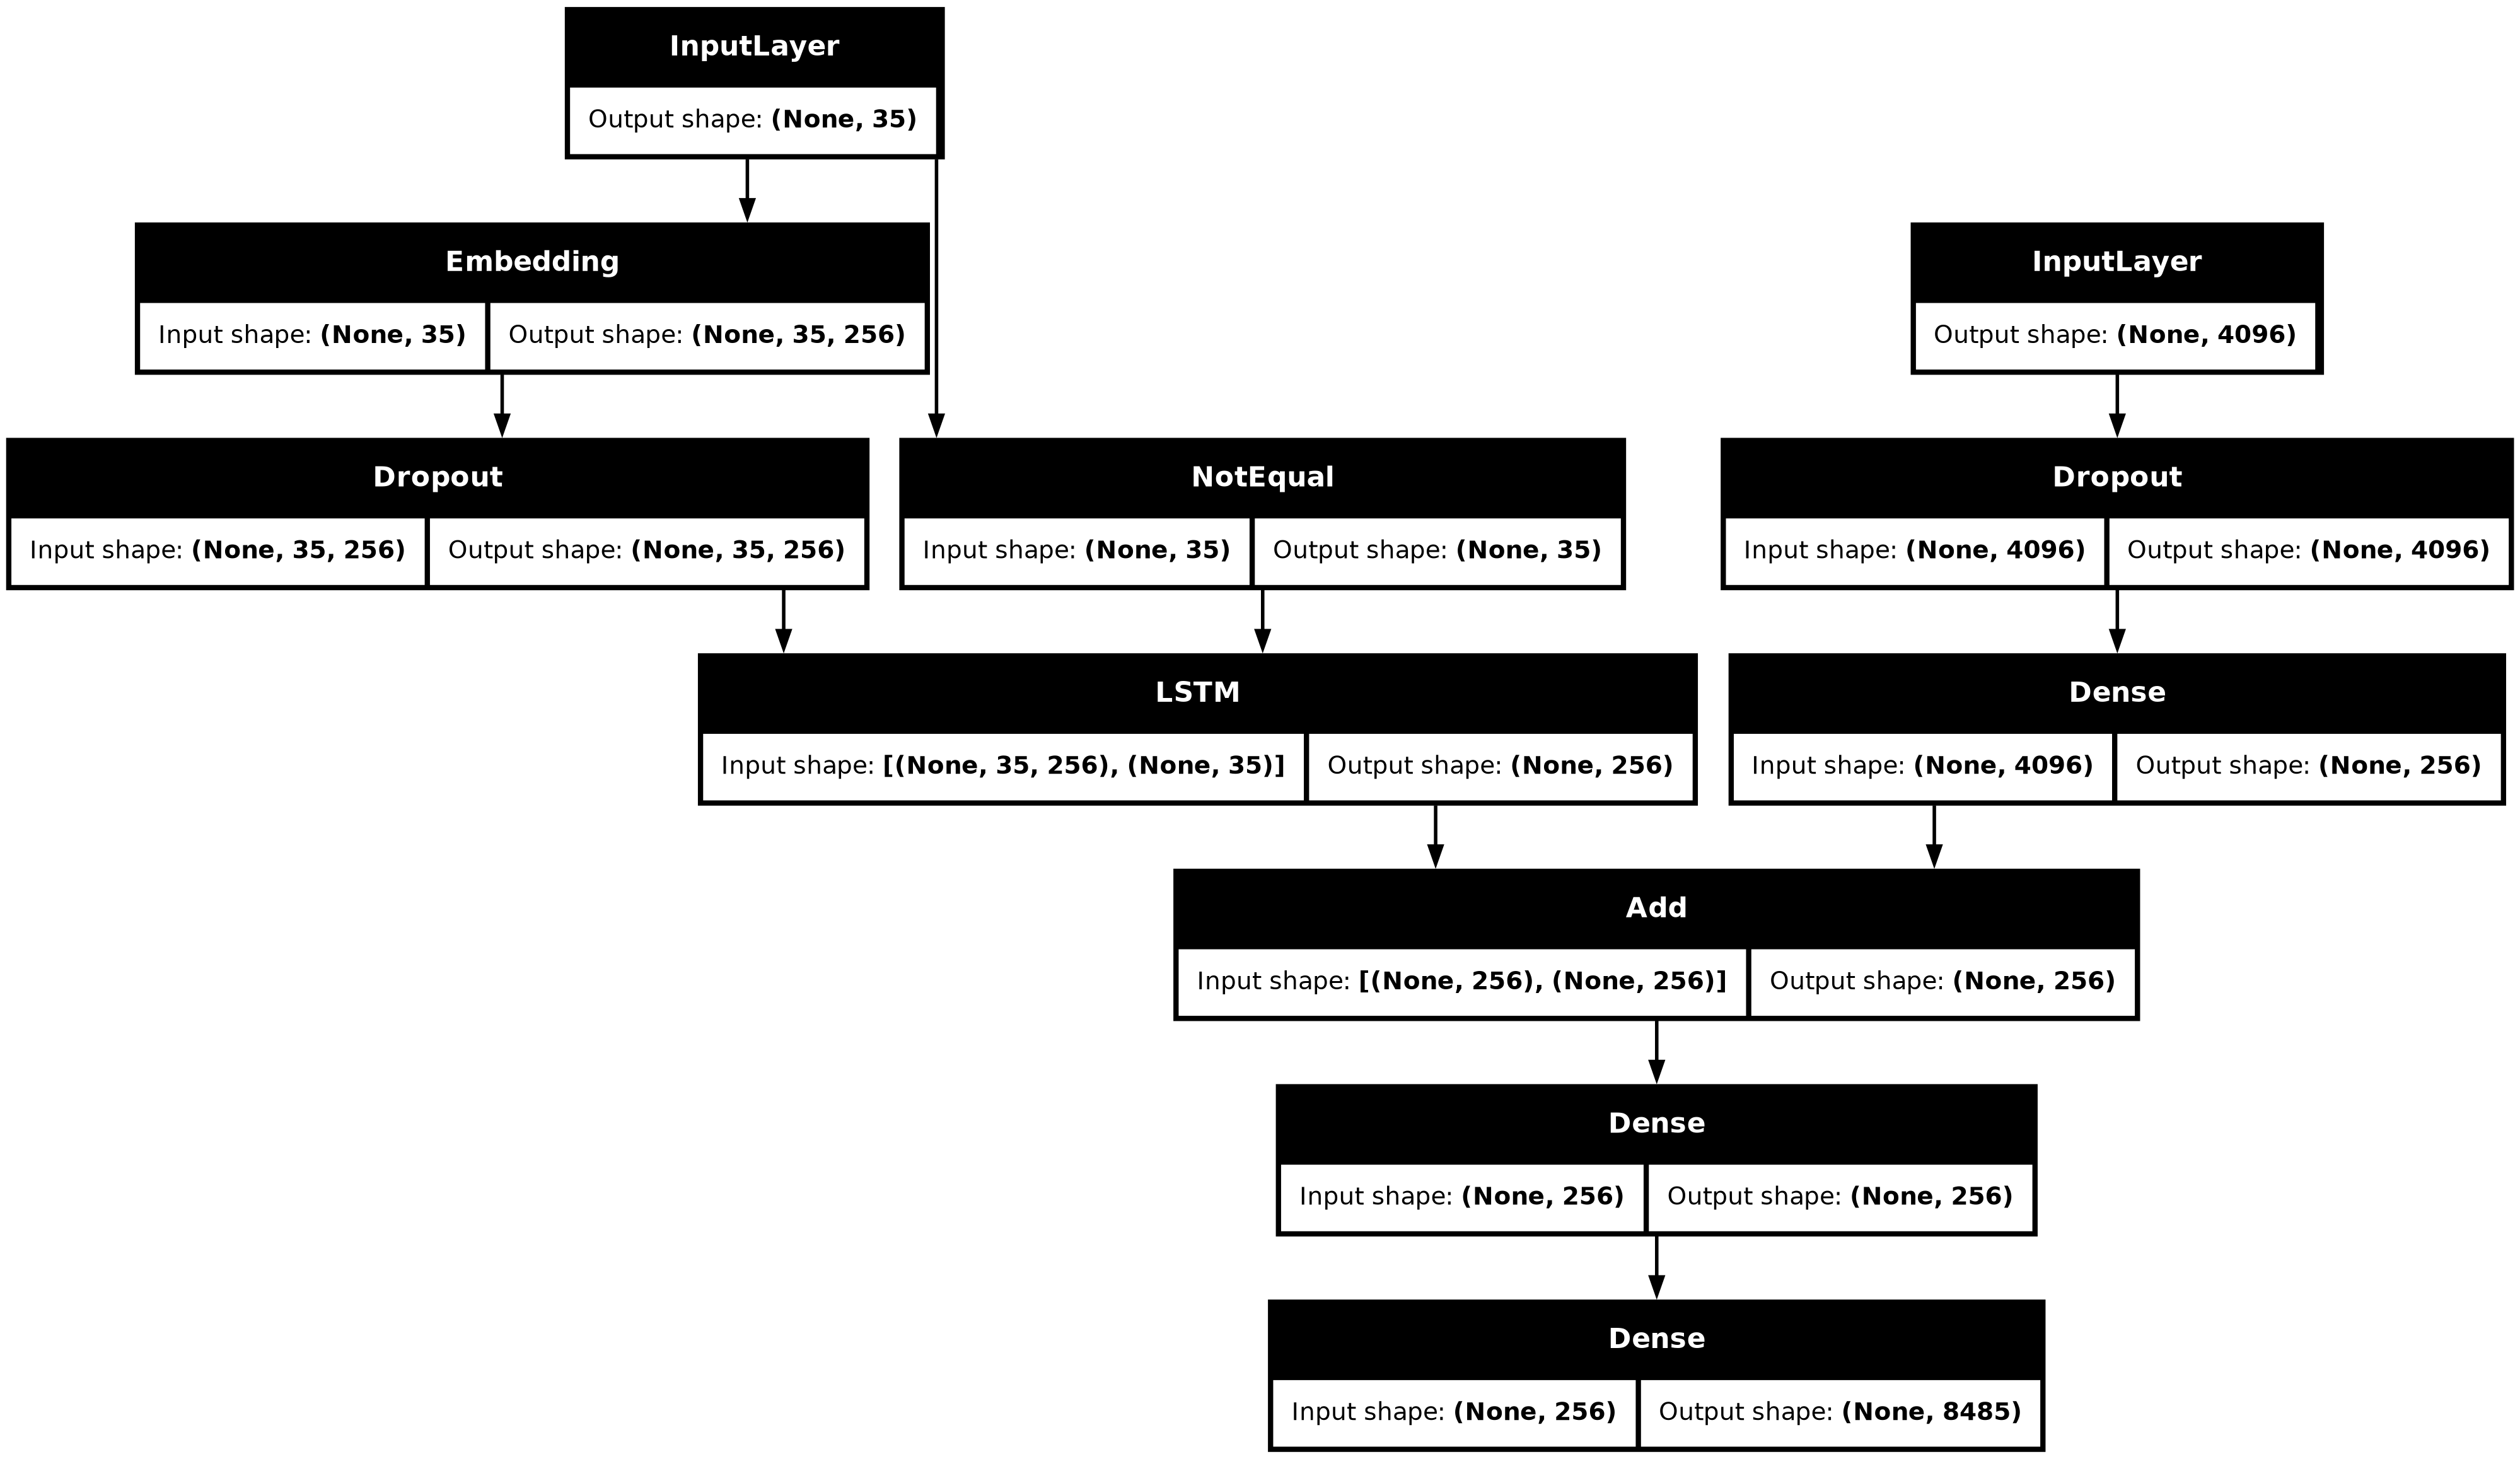

In [52]:
plot_model(model,show_shapes=True)

## *Model Training*

In [53]:
epochs=20
batch_size=32
steps=len(train)//batch_size

for i in range(epochs):
    generator=data_generator(train,mapping, features, tokenizer, max_length,vocab_size,batch_size)
    model.fit(generator,epochs=1,steps_per_epoch=steps,verbose=1)

227/227 ━━━━━━━━━━━━━━━━━━━━ 470s 2s/step - loss: 5120.8110
227/227 ━━━━━━━━━━━━━━━━━━━━ 57s 250ms/step - loss: 14.9439
227/227 ━━━━━━━━━━━━━━━━━━━━ 56s 247ms/step - loss: 12.5694
227/227 ━━━━━━━━━━━━━━━━━━━━ 56s 248ms/step - loss: 11.7940
227/227 ━━━━━━━━━━━━━━━━━━━━ 55s 243ms/step - loss: 5.4237
227/227 ━━━━━━━━━━━━━━━━━━━━ 57s 250ms/step - loss: 5.2439
227/227 ━━━━━━━━━━━━━━━━━━━━ 56s 247ms/step - loss: 5.0790
227/227 ━━━━━━━━━━━━━━━━━━━━ 56s 246ms/step - loss: 4.8043
227/227 ━━━━━━━━━━━━━━━━━━━━ 56s 249ms/step - loss: 4.6971
227/227 ━━━━━━━━━━━━━━━━━━━━ 57s 250ms/step - loss: 4.8497
227/227 ━━━━━━━━━━━━━━━━━━━━ 56s 249ms/step - loss: 4.4244
227/227 ━━━━━━━━━━━━━━━━━━━━ 57s 250ms/step - loss: 4.3024
227/227 ━━━━━━━━━━━━━━━━━━━━ 58s 256ms/step - loss: 4.3218
227/227 ━━━━━━━━━━━━━━━━━━━━ 57s 250ms/step - loss: 4.1340
227/227 ━━━━━━━━━━━━━━━━━━━━ 57s 253ms/step - loss: 4.0208
227/227 ━━━━━━━━━━━━━━━━━━━━ 59s 262ms/step - loss: 3.9337
227/227 ━━━━━━━━━━━━━━━━━━━━ 56s 249ms/step - loss: 

## *Model Saving*

In [57]:
path='/kaggle/working/model.h5'
model.save(path)

In [ ]:
# model=load_model('D:/model.h5')

## *Generate Caption for an Image*

In [58]:
def indx_to_word(integer,tokenizer):
    for word,index in tokenizer.word_index.items():
        if index==integer:
            return word
    return None

In [76]:
def predict_caption(model, image, tokenizer, max_length):
    in_text = 'startseq'
    for i in range(max_length):
        seq = tokenizer.texts_to_sequences([in_text])[0]
        pad_seq = pad_sequences([seq], maxlen=max_length)  # Corrected parameter name
        y_pred = model.predict([image, pad_seq], verbose=0)
        y_pred = np.argmax(y_pred)  # Get the predicted word index
        word = indx_to_word(y_pred, tokenizer)
        if word is None:
            break
        in_text += " " + word
        if word == 'endseq':
            break
    return in_text


## *Model Evaluation*

In [77]:
# Prepare data for BLEU score calculation
actual, predicted = list(), list()

for key in tqdm(test):
    captions = mapping[key]
    y_pred = predict_caption(model, features[key], tokenizer, max_length)
    y_pred = y_pred.split()  # Split predicted caption into tokens
    
    actual_caption = [caption.split() for caption in captions]  # Correctly split captions into tokens
    actual.append(actual_caption)
    predicted.append(y_pred)

100%|██████████| 810/810 [10:29<00:00,  1.29it/s]


In [79]:
print('BLEU Score-1:',corpus_bleu(actual,predicted))
print('BLEU Score-1:',corpus_bleu(actual,predicted,weights=(1,0,0,0)))
print('BLEU Score-2:',corpus_bleu(actual,predicted,weights=(0.5,0.5,0,0)))
print('BLEU Score-3:',corpus_bleu(actual,predicted,weights=(0.25,0.25,0.25,0.25)))

BLEU Score-1: 0.033414105524888126
BLEU Score-1: 0.45668724279835393
BLEU Score-2: 0.21382230908546718
BLEU Score-3: 0.033414105524888126


## *Visualizing The Results*

In [80]:
def visualize(img_name):
    img_id=img_name.split('.')[0]
    img_path=os.path.join(base_dir,"Images",img_name)
    image=Image.open(img_path)
    captions=mapping[img_id]

    print('Actual')
    for caption in captions:
        print(caption)

    y_pred=predict_caption(model,features[img_id],tokenizer,max_length)

    print('Predicted')

    print(y_pred)

    plt.imshow(image)

Actual
startseq black dog leaps over log endseq
startseq grey dog is leaping over fallen tree endseq
startseq large black dog leaps fallen log endseq
startseq mottled black and grey dog in blue collar jumping over fallen tree endseq
startseq the black dog jumped the tree stump endseq
Predicted
startseq man in the pink shirt is running through the water endseq


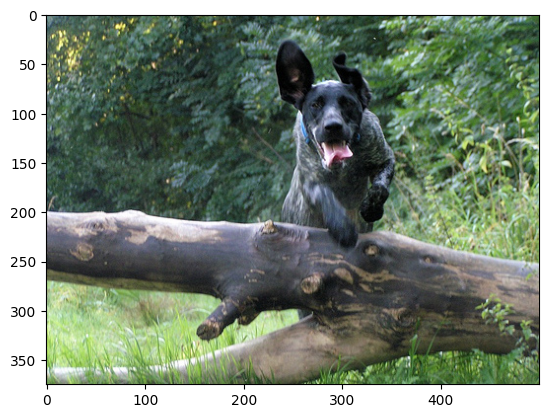

In [81]:
img_name="1015584366_dfcec3c85a.jpg"
visualize(img_name)